In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from utils import read_filenames, prepare_datasets
from processing import find_bounding_boxes, extract_and_resize, process_image, load_image, convert_to_feature_vectors
from data_generator import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/Users/michal/Documents/studia/sem4/WdUM/Galaxies_Clusterization/data/images'
#path = '/Users/julia/Desktop/semestr-4/ml/projekty/projekt-2/galaxies_data/images_gz2/images'

galaxies = read_filenames(path)

We select only 100k images and split them in train, validation and test datasets in the proportions: 0.8 $\times$ 0.8, 0.8 $\times$ 0.2 and 0.2 of the whole dataset, respectively. All the details and implementation of the function prepare_datasets can be found in src/utils.py

In [3]:
galaxies_train, galaxies_val, galaxies_test = prepare_datasets(galaxies, 100000)

In [4]:
print(f'Size of train sample: {len(galaxies_train)}')
print(f'Size of validation sample: {len(galaxies_val)}')
print(f'Size of test sample: {len(galaxies_test)}')

Size of train sample: 64000
Size of validation sample: 16000
Size of test sample: 20000


## Extracting galaxy from an image

We will use the fact that galaxy of our interest is in the center of the image and using bounding boxes we will find appropriate square to crop the image.

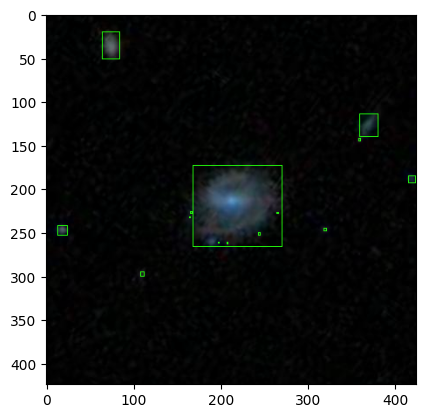

In [5]:
image = load_image(galaxies_train[3721])

image_bb = find_bounding_boxes(image, 30)
plt.imshow(image_bb)
plt.show()

Out of all of found bounding boxes we choose the one that is both close to the center and not relatively small in size. Implementation can be found in src/processing.py file, extract_and_resize function. Below we show results of such an operation.

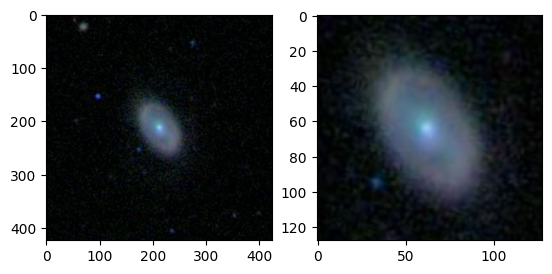

In [15]:
image = load_image(galaxies_train[random.randint(0, len(galaxies_train) - 1)])
plt.subplot(1, 2, 1)
plt.imshow(image)

image_cropped = extract_and_resize(image, 20)
plt.subplot(1, 2, 2)
plt.imshow(image_cropped)
plt.show()

Next steps in processing an image are converting to grayscale and normalizing. Below we show final result of image processing.

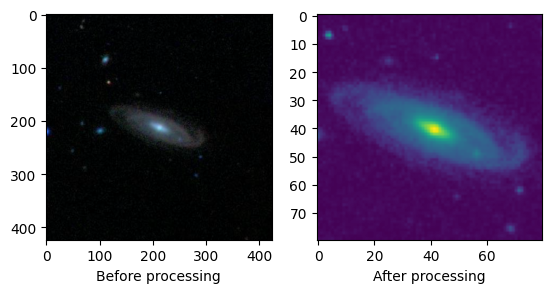

In [36]:
random_galaxy = galaxies_train[random.randint(0, len(galaxies_train) - 1)]

image = cv.imread(random_galaxy)
plt.subplot(1, 2, 1)
plt.xlabel('Before processing')
plt.imshow(image)

processed_image = process_image(random_galaxy, 20, (80, 80))
plt.subplot(1, 2, 2)
plt.xlabel('After processing')
plt.imshow(processed_image)
plt.show()

## Autoencoder for image denoising

Training will be performed in batches in order to reduce RAM usage. ImageDataGenerator is a class that yields batches of images for training a model. Class implementation can be found in src/data_generator.py

In [37]:
batch_size = 32
img_size = 80

train_gen = ImageDataGenerator(galaxies_train, batch_size, img_size)
val_gen = ImageDataGenerator(galaxies_val, batch_size, img_size)

In [47]:
encoder = Sequential([
    Flatten(input_shape=[80, 80]),
    Dense(1000, activation="relu"),
    Dense(800, activation="relu"),
    Dense(600, activation="relu"),
    Dense(400, activation="relu"),
    Dense(200, activation="relu"),
    Dense(100, activation="relu"),
    Dense(50, activation="relu")
])

# Define the decoder
decoder = Sequential([
    Dense(100, input_shape=[50], activation="relu"),
    Dense(200, activation="relu"),
    Dense(400, activation="relu"),
    Dense(600, activation="relu"),
    Dense(800, activation="relu"),
    Dense(1000, activation="relu"),
    Dense(80*80, activation="sigmoid"),
    Reshape([80, 80])
])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [49]:
for epoch in range(10):
    print(f"Epoch {epoch + 1}/{10}")

    autoencoder.fit(
        train_gen,
        epochs=1,
        validation_data=val_gen,
    )

    train_gen.on_epoch_end()
    val_gen.on_epoch_end()

    print()

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 174s 87ms/step - loss: 0.2840 - val_loss: 0.2823

Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 181s 90ms/step - loss: 0.2830 - val_loss: 0.2818

Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 480s 240ms/step - loss: 0.2827 - val_loss: 0.2818

Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 218s 109ms/step - loss: 0.2822 - val_loss: 0.2813

Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 185s 92ms/step - loss: 0.2818 - val_loss: 0.2808

Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 186s 93ms/step - loss: 0.2813 - val_loss: 0.2807

Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 187s 93ms/step - loss: 0.2806 - val_loss: 0.2807

Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 190s 95ms/step - loss: 0.2812 - val_loss: 0.2804

Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 206s 103ms/step - loss: 0.2811 - val_loss: 0.2804

Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 190s 95ms/step - loss: 0.2811 - val_loss: 0.2805



Lets see results of our autoencoder.

In [192]:
processed_sample_val = []

for galaxy in galaxies_val[:100]:
    image = process_image(galaxy, 30, target_size=(80, 80))
    processed_sample_val.append(image)

processed_sample_val = np.array(processed_sample_val)

In [193]:
predicitions = autoencoder.predict(processed_sample_val[:100])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


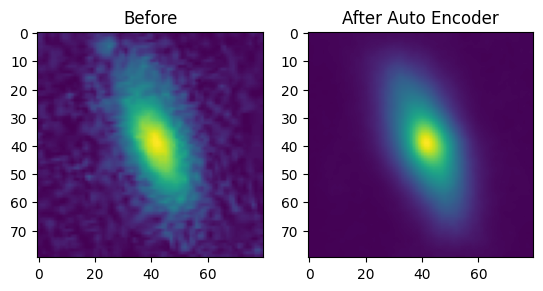

In [199]:
index = random.randint(0, len(predicitions) - 1)

plt.subplot(1, 2, 1)
plt.title("Before")
plt.imshow(processed_sample_val[index])

plt.subplot(1, 2, 2)
plt.title("After Auto Encoder")
plt.imshow(predicitions[index])
plt.show()

Saving the model for future usage.

In [ ]:
autoencoder.save('../models/autoencoder.keras')

## Converting to feature vectors

We will use pretrained CNN - VGG16 and remove top classification layers and extract features from the intermediate layers. Then we will use PCA on features reduce dimensionality.

In [4]:
model = VGG16(include_top=False, input_shape=(80, 80, 3)) # VGG16 accepts only 3 inputs channels
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

Loading our trained autoencoder

In [5]:
autoencoder = load_model('../models/autoencoder.keras')

The function convert_to_feature_vectors processes the images, denoises them using autoencoder and then feeds them to VGG16 model with top layers removed as described above. Implementation can be found in src/processing.py

In [6]:
features = convert_to_feature_vectors(galaxies_train, autoencoder, model, 10000)

1000 out of 10000
2000 out of 10000
3000 out of 10000
4000 out of 10000
5000 out of 10000
6000 out of 10000
7000 out of 10000
8000 out of 10000
9000 out of 10000
10000 out of 10000


In [7]:
features.shape

(10000, 12800)

Before performing PCA we will scale the data

In [8]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

Choosing the number of components

In [9]:
pca = PCA(n_components=700, random_state=21)
pca.fit(features)

PCA(n_components=700, random_state=21)

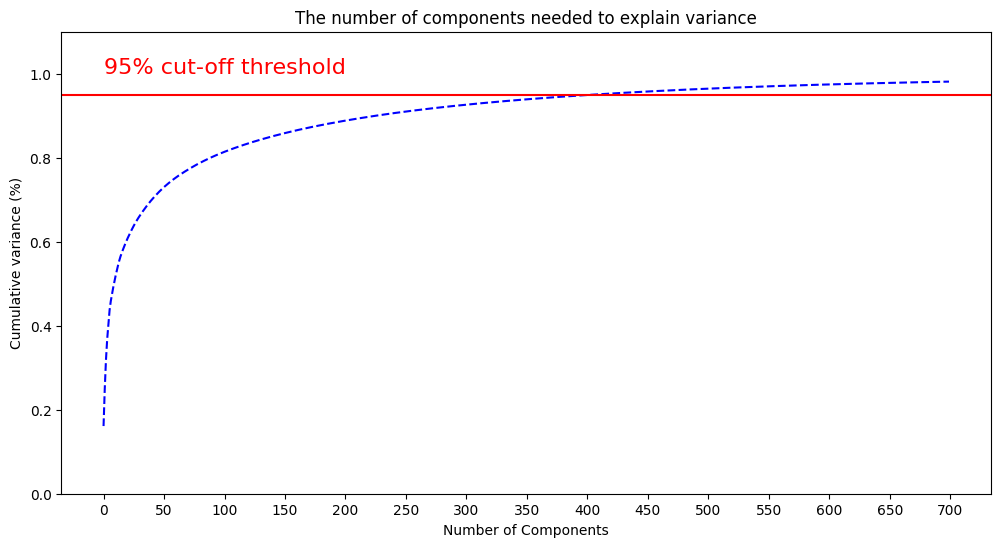

In [10]:
plt.figure(figsize=(12, 6))

xi = np.arange(0, 700, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 701, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 1, '95% cut-off threshold', color = 'red', fontsize=16)

plt.show()

From the above plot we see that after achieving 95% threshold the percent of variance explainablity grows slowly. Thus, we believe that choosing number of components, such that 95% percent of variance is explained, perfectly balances size and interpretability of the data.

In [13]:
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95)

In [14]:
pca = PCA(n_components=404, random_state=21)
pca.fit(features)

PCA(n_components=404, random_state=21)

In [16]:
features_reduced = pca.transform(features)

In [18]:
print(f"Components before PCA: {features.shape[1]}")
print(f"Components after PCA: {features_reduced.shape[1]}")

Components before PCA: 12800
Components after PCA: 404


We will save feature vectors to be able to load them in clustering notebook.

In [20]:
np.save('../processing/feature_vectors.npy', features_reduced)